In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import plotly.express as px
import plotly.io as pio

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
from google.colab import files
uploaded = files.upload()


Saving fake_job_postings.csv to fake_job_postings.csv


In [24]:
import pandas as pd

df = pd.read_csv('fake_job_postings.csv')
df.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [25]:
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna(' ')

# Categorical columns → fill with default values
df.fillna({
    'location': 'Unknown',
    'department': 'Unknown',
    'salary_range': 'Not Specified',
    'employment_type': 'Not Specified',
    'required_experience': 'Not Specified',
    'required_education': 'Not Specified',
    'industry': 'Not Specified',
    'function': 'Not Specified'
}, inplace=True)


In [26]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing
for col in text_columns:
    df[col] = df[col].apply(preprocess_text)


In [27]:
df['text'] = df[text_columns].apply(lambda x: ' '.join(x), axis=1)


In [33]:
import plotly.express as px
import plotly.io as pio

# Set Plotly renderer for Google Colab
pio.renderers.default = 'colab'

# Convert to string for categorical plotting
df['fraudulent'] = df['fraudulent'].astype(str)

# Optional: sort categories for x-axis
df['fraudulent'] = pd.Categorical(df['fraudulent'], categories=['0', '1'], ordered=True)

# plot
fig = px.histogram(
    df,
    x='fraudulent',
    title='Distribution of Fraudulent vs Non-Fraudulent Job Postings',
    labels={'fraudulent': 'Fraudulent (0 = Real, 1 = Fake)'},
    color='fraudulent',
    color_discrete_sequence=['#1f77b4', '#ff7f0e']
)

# Style plot
fig.update_layout(
    template='plotly_dark',
    xaxis_title='Fraudulent',
    yaxis_title='Count',
    title_x=0.5,
    font=dict(family="Arial, sans-serif", size=14, color="white"),
    paper_bgcolor='#1e1e1e',
    plot_bgcolor='#1e1e1e',
    xaxis=dict(gridcolor='gray'),
    yaxis=dict(gridcolor='gray')
)

# Show interactive plot in Colab
fig.show()



In [29]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['text'])
y = df['fraudulent'].astype(int)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [31]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Accuracy: 0.9648

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5104
           1       0.78      0.38      0.51       260

    accuracy                           0.96      5364
   macro avg       0.87      0.69      0.75      5364
weighted avg       0.96      0.96      0.96      5364



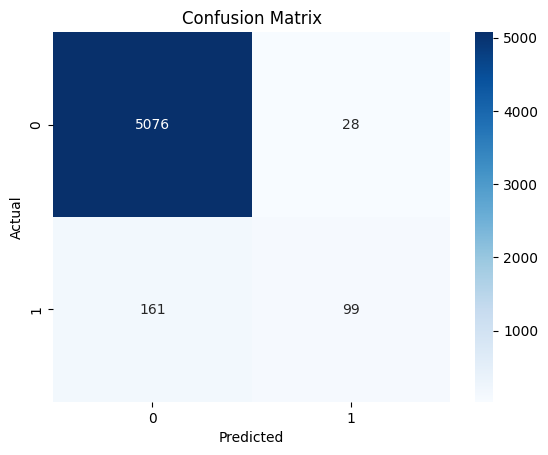

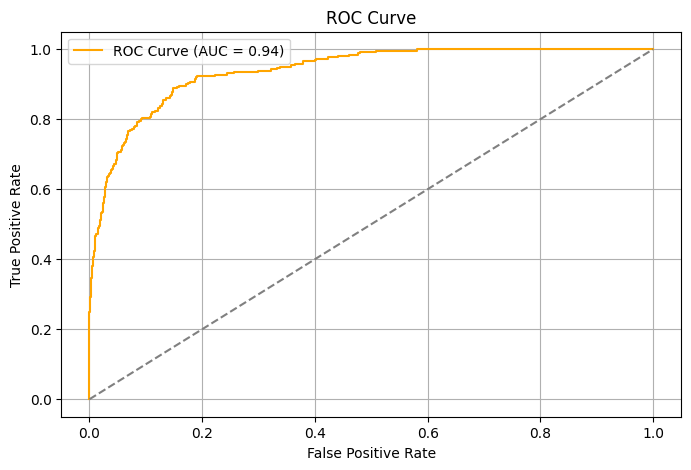

In [32]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
